**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive/')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive/


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/ISIC/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/ISIC/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir_train, labels='inferred', label_mode='int',
      class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
      img_width), shuffle=True, seed=123, validation_split=0.2, subset='training',
      interpolation='bilinear', follow_links=False, smart_resize=False
  )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir_train, labels='inferred', label_mode='int',
      class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
      img_width), shuffle=True, seed=123, validation_split=0.2, subset='validation',
      interpolation='bilinear', follow_links=False, smart_resize=False
  )

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

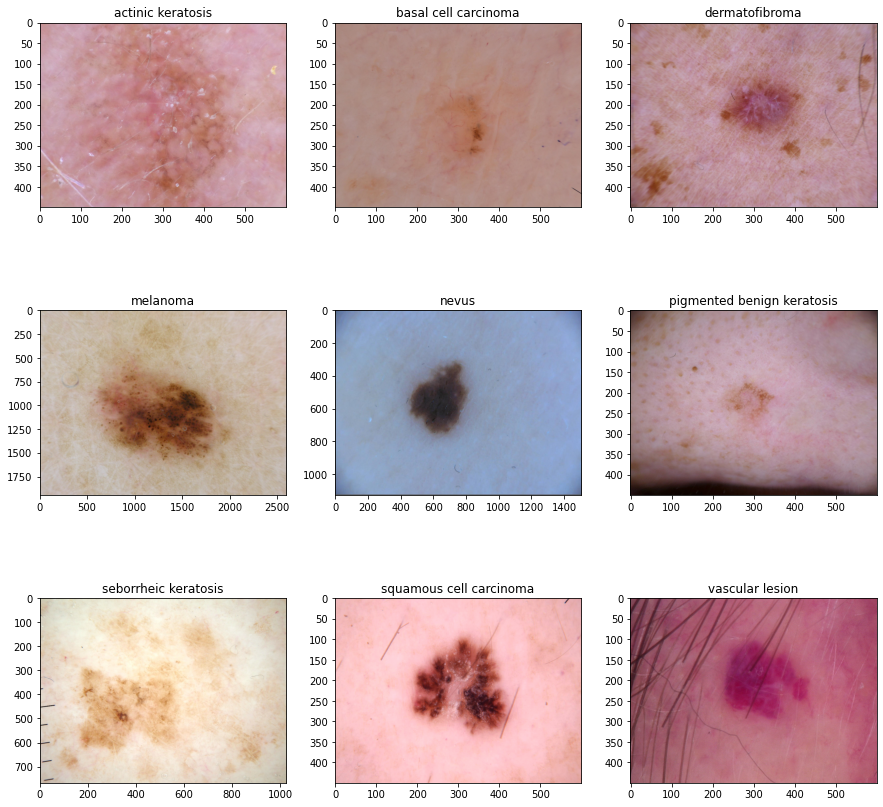

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(15, 15))
position = 1
img = None

for folder in class_names:
  ax = plt.subplot(3, 3, position)
  plt.title(folder)
  position = position + 1

  full_path = data_dir_train.resolve().as_uri() + '/' + folder
  full_path = full_path.replace('file:/', '')
  files = os.listdir(full_path)

  img = mpimg.imread(full_path + '/' + files[0])
  plt.imshow(img)

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(9)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 851s 1s/step - loss: 1.9927 - accuracy: 0.2296 - val_loss: 1.6477 - val_accuracy: 0.3801
Epoch 2/20
169/169 [==============================] - 3s 20ms/step - loss: 1.5389 - accuracy: 0.4195 - val_loss: 1.4082 - val_accuracy: 0.4878
Epoch 3/20
169/169 [==============================] - 3s 20ms/step - loss: 1.2611 - accuracy: 0.5323 - val_loss: 1.1846 - val_accuracy: 0.5612
Epoch 4/20
169/169 [==============================] - 3s 20ms/step - loss: 1.1482 - accuracy: 0.5727 - val_loss: 1.1980 - val_accuracy: 0.5687
Epoch 5/20
169/169 [==============================] - 3s 20ms/step - loss: 0.9565 - accuracy: 0.6489 - val_loss: 0.9839 - val_accuracy: 0.6333
Epoch 6/20
169/169 [==============================] - 3s 20ms/step - loss: 0.8008 - accuracy: 0.7149 - val_loss: 0.9030 - val_accuracy: 0.6778
Epoch 7/20
169/169 [==============================] - 3s 20ms/step - loss: 0.6802 - accuracy: 0.7628 - val_loss: 0.8989 - val_accuracy: 0.6971

### Visualizing training results

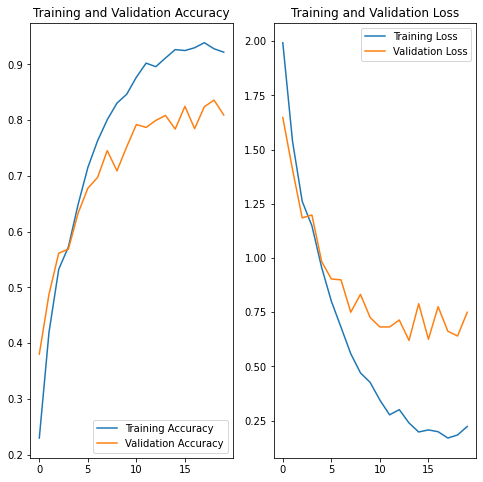

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### The model has clearly **overfitted** on the training data and does not perform as well on the validation data
---

In [ ]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(
    height_factor=0.2, width_factor=0.2, fill_mode='reflect',
    interpolation='bilinear', seed=123, fill_value=0.0
  )
])



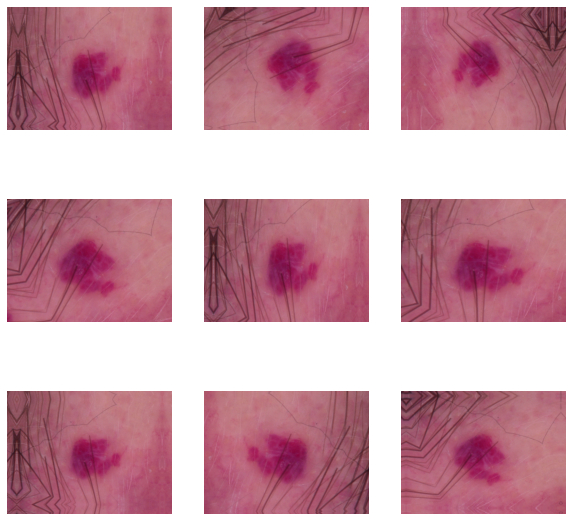

In [ ]:
# Visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

image = tf.expand_dims(img, 0)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(9)
])

### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 5s 23ms/step - loss: 1.8294 - accuracy: 0.3003 - val_loss: 1.7449 - val_accuracy: 0.3623
Epoch 2/20
169/169 [==============================] - 4s 22ms/step - loss: 1.5466 - accuracy: 0.4086 - val_loss: 1.4356 - val_accuracy: 0.4588
Epoch 3/20
169/169 [==============================] - 4s 22ms/step - loss: 1.4038 - accuracy: 0.4564 - val_loss: 1.4093 - val_accuracy: 0.4514
Epoch 4/20
169/169 [==============================] - 4s 22ms/step - loss: 1.3651 - accuracy: 0.4638 - val_loss: 1.4829 - val_accuracy: 0.4447
Epoch 5/20
169/169 [==============================] - 4s 22ms/step - loss: 1.3177 - accuracy: 0.4841 - val_loss: 1.3103 - val_accuracy: 0.4981
Epoch 6/20
169/169 [==============================] - 4s 22ms/step - loss: 1.2747 - accuracy: 0.5019 - val_loss: 1.3131 - val_accuracy: 0.4974
Epoch 7/20
169/169 [==============================] - 4s 22ms/step - loss: 1.2772 - accuracy: 0.5069 - val_loss: 1.3274 - val_accuracy: 0.4833

### Visualizing the results

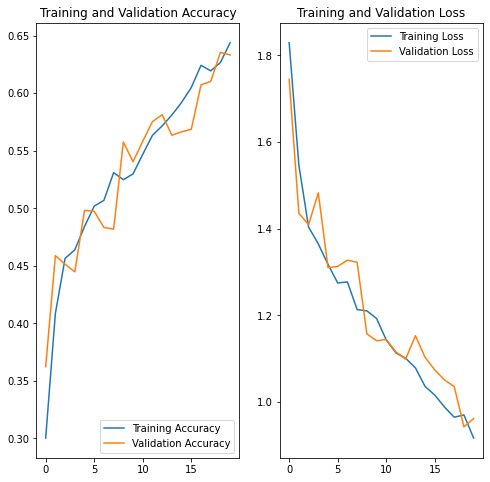

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Findings:** From the graph above we can see that the data augmentation and the addition of a droupout layer has eliminated overfitting and the model has a comparable test and validation accuracy. However, the overall accuracy has dropped.


---



#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

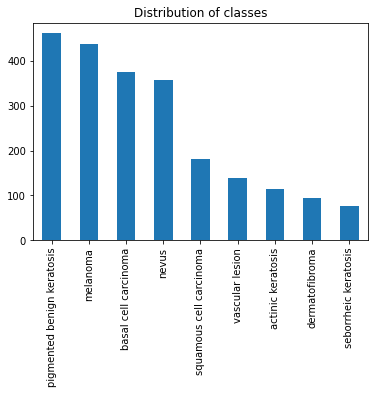

In [ ]:
## Your code goes here.
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

pd.value_counts(original_df['Label']).plot.bar()
plt.title('Distribution of classes')
plt.show()

#### Write your findings here: 
#### Which class has the least number of samples?
#### **Answer:** seborrheic keratosis

#### Which classes dominate the data in terms proportionate number of samples?
#### **Answer:** 
1. pigmented benign keratosis
2. melanoma
3. basal cell carcinoma
4. nevus


#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset = data_dir_train.resolve().as_uri().replace('file:/', '') + "/"
print(path_to_training_dataset)
import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

//content/gdrive/MyDrive/ISIC/Train/
Initialised with 114 image(s) found.
Output directory set to //content/gdrive/MyDrive/ISIC/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD41409F910>: 100%|██████████| 500/500 [00:19<00:00, 25.28 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to //content/gdrive/MyDrive/ISIC/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD4140A1FD0>: 100%|██████████| 500/500 [00:18<00:00, 26.59 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to //content/gdrive/MyDrive/ISIC/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD414176FD0>: 100%|██████████| 500/500 [00:18<00:00, 26.37 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to //content/gdrive/MyDrive/ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD4140FC190>: 100%|██████████| 500/500 [01:34<00:00,  5.29 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD414122A50>:   0%|          | 1/500 [00:00<01:03,  7.86 Samples/s]

Initialised with 357 image(s) found.
Output directory set to //content/gdrive/MyDrive/ISIC/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=576x768 at 0x7FD41405BD50>: 100%|██████████| 500/500 [01:23<00:00,  6.00 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to //content/gdrive/MyDrive/ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD4731F3990>: 100%|██████████| 500/500 [00:19<00:00, 25.67 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to //content/gdrive/MyDrive/ISIC/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD473213910>: 100%|██████████| 500/500 [00:42<00:00, 11.78 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to //content/gdrive/MyDrive/ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD4147D9BD0>: 100%|██████████| 500/500 [00:19<00:00, 26.19 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to //content/gdrive/MyDrive/ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD47411F8D0>: 100%|██████████| 500/500 [00:19<00:00, 25.80 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: Label, dtype: int64

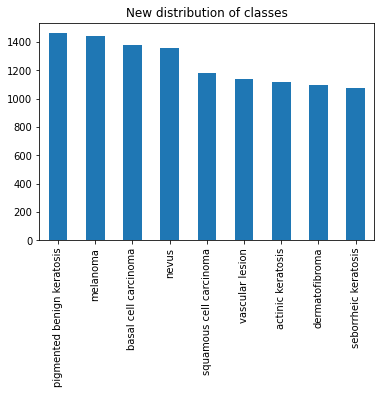

In [ ]:
pd.value_counts(new_df['Label']).plot.bar()
plt.title('New distribution of classes')
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [ ]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### Create your model (make sure to include normalization)

In [ ]:
## your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(9)
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 51s 176ms/step - loss: 1.8119 - accuracy: 0.2978 - val_loss: 1.6269 - val_accuracy: 0.3930
Epoch 2/30
281/281 [==============================] - 49s 171ms/step - loss: 1.4425 - accuracy: 0.4377 - val_loss: 1.3848 - val_accuracy: 0.4579
Epoch 3/30
281/281 [==============================] - 48s 167ms/step - loss: 1.3675 - accuracy: 0.4607 - val_loss: 1.5034 - val_accuracy: 0.4401
Epoch 4/30
281/281 [==============================] - 48s 169ms/step - loss: 1.3035 - accuracy: 0.4860 - val_loss: 1.3264 - val_accuracy: 0.4984
Epoch 5/30
281/281 [==============================] - 48s 169ms/step - loss: 1.2352 - accuracy: 0.5173 - val_loss: 1.2031 - val_accuracy: 0.5300
Epoch 6/30
281/281 [==============================] - 49s 171ms/step - loss: 1.1812 - accuracy: 0.5397 - val_loss: 1.1543 - val_accuracy: 0.5505
Epoch 7/30
281/281 [==============================] - 48s 170ms/step - loss: 1.1450 - accuracy: 0.5557 - val_loss: 1.2169 - val_ac

#### Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

#### After addressing the class imbalance the traning and validation accuracy has improved significantly

---